In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
pd.options.display.max_rows = 999
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from pprint import pprint

We already have an example of Random Forest Classifier on image classification which performs pretty well. Let's try <b>Random Forest Regressor</b> on a <b>time series of dialy mean UV indices</b> measured at King's Park from 2000 to 2021.<br>
Data: https://data.gov.hk/en-data/dataset/hk-hko-rss-daily-maximum-mean-uv-index/resource/dc03f239-3084-4b4b-8e2e-3febe66e550a

# Load dataset
- Load daily_KP_UV_ALL.csv as dataframe, neglect descriptive rows
- Neglect Year = 1999
- Rename columns to English only for easier recall later

,Year,Month,Day,Value,Completeness
153,2000,1.0,1.0,2,C
154,2000,1.0,2.0,2,C
155,2000,1.0,3.0,2,C
156,2000,1.0,4.0,2,C
157,2000,1.0,5.0,2,C


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7850 entries, 153 to 8002
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          7850 non-null   object 
 1   Month         7850 non-null   float64
 2   Day           7850 non-null   float64
 3   Value         7850 non-null   object 
 4   Completeness  7846 non-null   object 
dtypes: float64(2), object(3)
memory usage: 368.0+ KB


# Create date index
- Using columns Year, Month and Day, create Date column using datetime.strptime()
- Set Date as index

In [4]:
# create date column to investigate data as a time series
from datetime import datetime


# Drop unused column
- Drop column Completeness which won't be used later.

# Fill missing UV value
- Replace all *** of Value column by forward-fill followed by backward fill 

In [6]:
# fill missing value and convert to float


# Visualize the time series
- Plot the first 1000 rows of UV values of df_train to see if there is any pattern

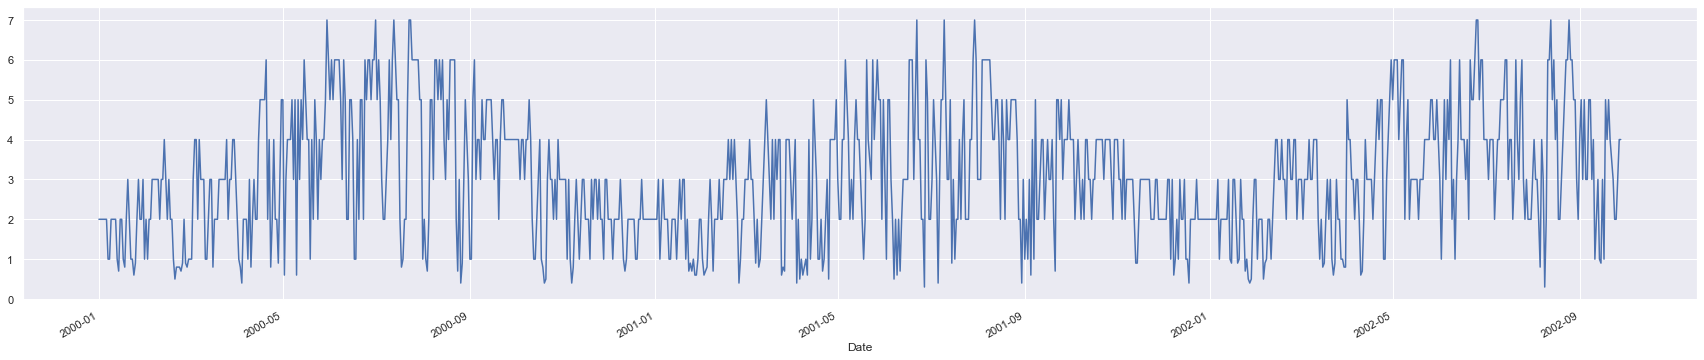

# Lag features
- Creat lag time series as new features, which could help measure how past values of the series affect future values, aka <b>autocorrelation</b>.

## Autocorrelation Function (ACF) plot 
- Autocorrelation measures similarily between a time series and its lagged version by caculating the correlation between the two.
- Autocorrelation plot (ACF plot) shows the correlation between a time series and its different lags in a plot.
- The ACF value for each lag, like the Pearson coefficient, ranges from -1 to 1, where positive value implies positively correlated and negative values implies negatively correlated, 0 means independent.
- Using plot_acf function of statsmodels library, create an ACF plot with lags=364. (https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)

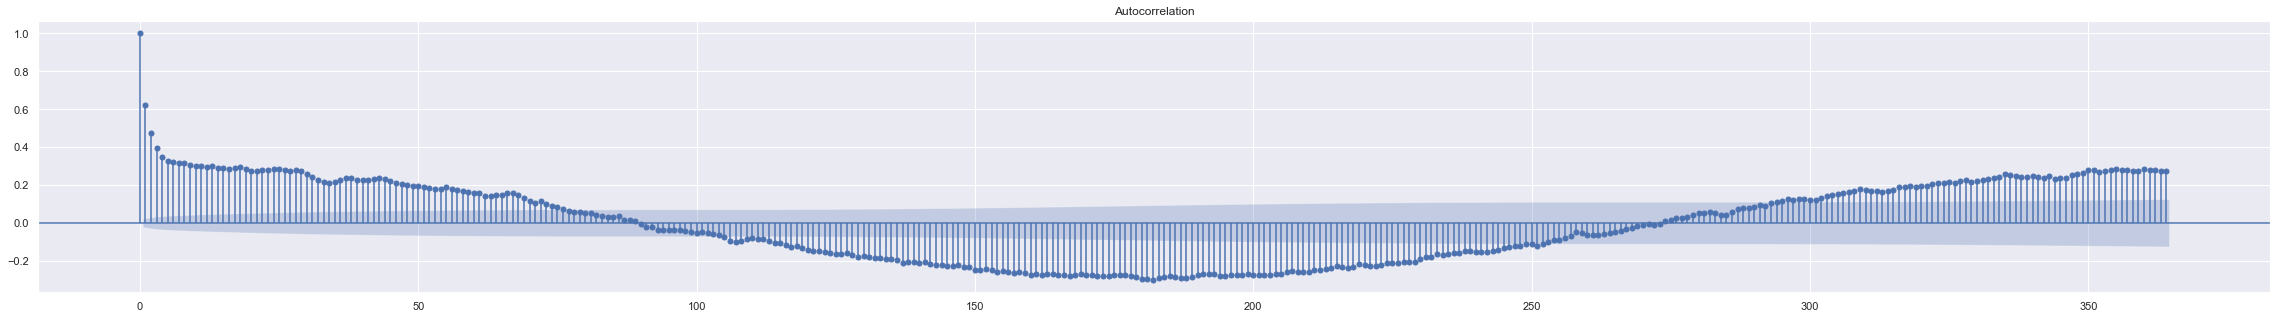

In [8]:
# ACF plot
from statsmodels.graphics.tsaplots import plot_acf


- There is 95% confidence that the two series are independent if the ACF value lies in the blue region.
- Lag 0 has ACF=1 because the time series should be perfectly positively correlated to itself.
- The sinusoidal pattern of ACF plot indicates that the time series has repeated pattern yearly.

From the plot it seems that the time series is correlated significantly with quite a lot of days in a year. However, there is a chance that many of them are duplicated (i.e. lags are also correlated with one another). That comes to <b>Partail Autocorrelation Function (PACF) plot</b>.

## Partial Autocorrelation Function (PACF) plot

- PACF gives the autocorrelation of a time series with its lagged series <b>where the dependence of the two time series with  lagged series before are removed</b>.
- Notationally speaking, given $z_t$ the original time series and $z_{t+k}$ the lag k of $z_t$, the partial autocorrelation between them, denoted by $\alpha(k)$, is given by:<br><br>
$$\alpha(k) = corr(z_{t}-P_{t,k}(z_t), z_{t+k}-P_{t,k}(z_t+k))$$
<br>where $P_{t,k}(x)$ is the orthogonal projection of x on the vector space spanned by the lagged series in-between (i.e. $z_{t+1}, z_{t+2},..., z_{t+k-1}$).
- Using plot_pacf function of statsmodels library, create an PACF plot with lags=364.

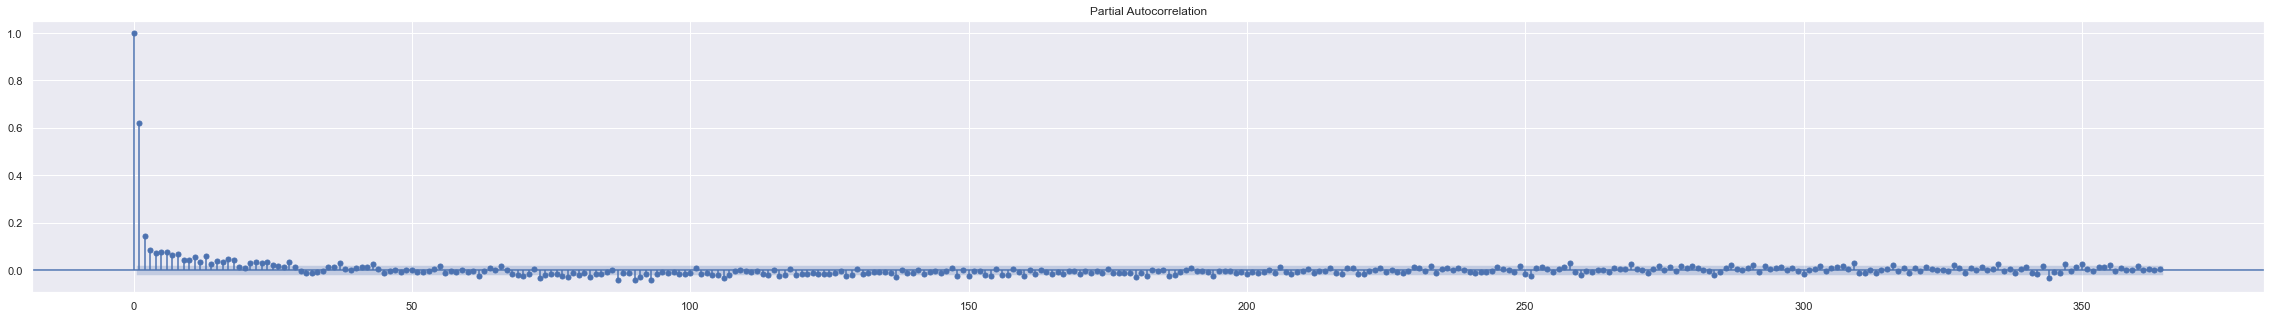

In [9]:
# PACF plot
from statsmodels.graphics.tsaplots import plot_pacf


This shows that actually the current UV value is only highly depending on values in the first few lags.

You may also use pacf function of statsmodels to find their numerical values and confidence intervals.

In [10]:
# get pacf values and 95% confidence intervals
from statsmodels.tsa.stattools import pacf
pacf_values, clevels = pacf(df['Value'], nlags=364, alpha=.05)

## Create lag features
- We know from PACF that the first few lags has most significant effect on the time series, anyway we will use all lags here and left it for the model to decide which lags are more important.
- Using pandas.Series.shift, create 364 lag columns lag 1 to lag 364 with name t_x where x is the number of lag.
- Drop rows of df with NaN as sklearn random forest model does not accept NaN.

In [11]:
# create lag features


# Split dataframe into train set and test set
- Split df into df_train and df_test, where df_train consists of data from 1999 to 2020, df_test consists of data in 20201

In [12]:
# split data to train and test set, use model to predict value in 2021


df_train.shape (7305, 368)
df_test.shape (181, 368)


# Train and test a random forest regressor model
- Using sklearn, train the random forest regressor with train set.

In [14]:
%%time
# train random forest regressor
from sklearn.ensemble import RandomForestRegressor


Wall time: 2min 21s


RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=42)

- Use the model to predict the test set and evaluate model performance using mean absolute percentage error metrics of sklearn.

In [15]:
# mean absolute percentage error of prediction
from sklearn.metrics import mean_absolute_percentage_error


MAPE 0.4339948237305972
MAE 0.8059364640883977


- Plot the real and predicted values of test set on the same graph

<ipython-input-16-a94d0e9058b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predict'] = ypred


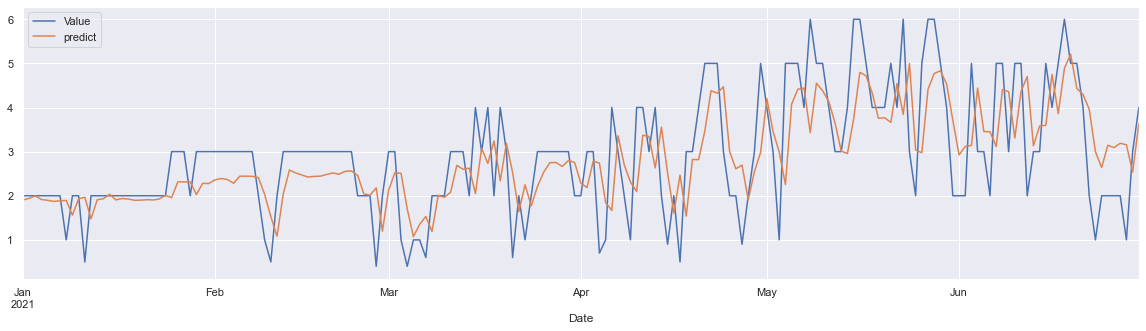

In [16]:
# plot prediction and true values on the same graph


- Plot the real and predicted values of train set on the same graph as well

<ipython-input-17-a8ba68d69bd3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['predict'] = train_pred


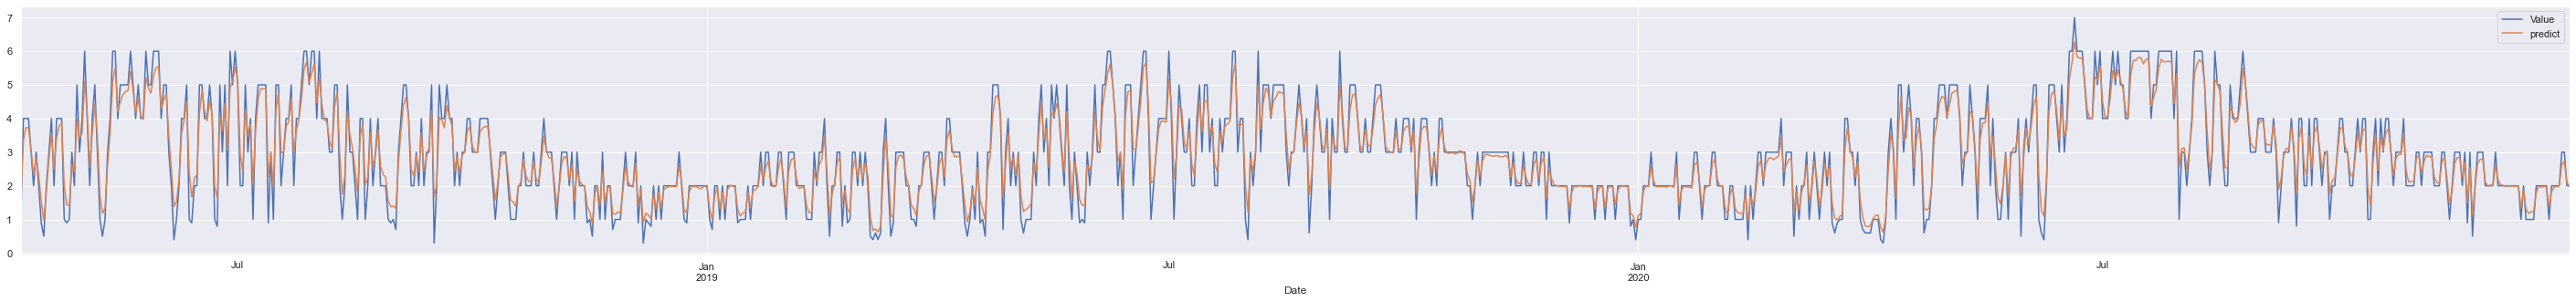

In [17]:
# plot the training part


- We can see that the prediction in test set lags behind the real values, it is reasonable since only lag features are used for prediction in our example.
- The mean absolute percentage error is ~44%, which has great space to improve. In this example we aim at showing that random forest can be applied on time series data. More time series analysis feature engineering techniques are required to obtain better result, which may be covered in later lessons. 

# View feature importance of regression tree
- Let's plot a bar chart of feature importance of random forest regressor. One can refer to: <br>https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html.

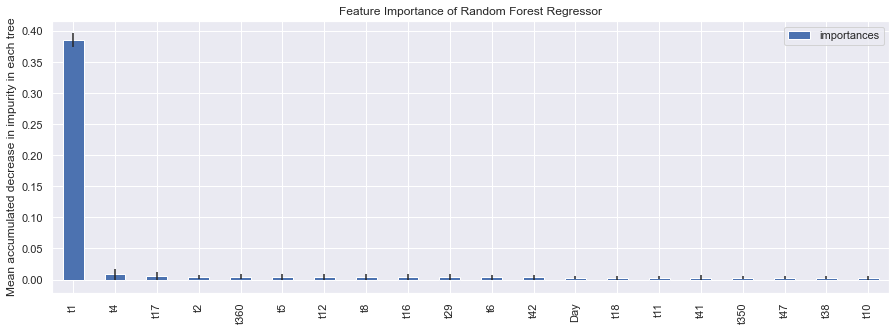

In [18]:
# plot feature importance of random forest regressor


One may think that why not ranking of feature importances matches with ranking of autocorrelation in ACF. It is because <b>low correlation just mean there is no linear relationship between the two series, it doesn't mean there is no information in the feature that predicts the target.</b>